# ICU LOS Prediction Notebook

This notebook implements a complete pipeline from raw data ingestion through final analysis. Each section is divided and explained with detailed markdowns, and code cells are broken into small, self-contained parcels for clarity and readability.


## 0. Setup & Imports

In this section, we install and import all required libraries. We also print environment information (Python, Dask, BigQuery, scikit-learn versions) to document dependencies.


In [1]:
# Install necessary packages (uncomment if necessary)
# In a notebook cell:
#!python3 -m pip install --upgrade bigframes
#!python3 -m pip install dask dask-bigquery google-cloud-bigquery "dask[distributed]" scikit-learn psutil nbformat seaborn

In [2]:
import time
import os
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from pandas.api.types import is_numeric_dtype

from google.cloud import bigquery
import dask
import dask.dataframe as dd
from dask_bigquery import read_gbq
from dask.distributed import Client, LocalCluster

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

/Users/hugotorgo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hugotorgo/Library/Python/3.9/lib/python/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
import sys
print("Python version:", sys.version)
print("Dask version:", dask.__version__)
print("BigQuery client version:", bigquery.__version__)
print("Scikit-learn version:", HistGradientBoostingRegressor.__module__.split('.')[0]

Python version: 3.9.6 (default, May  7 2023, 23:32:44) 
[Clang 14.0.3 (clang-1403.0.22.14.1)]
Dask version: 2024.8.0
BigQuery client version: 3.34.0
Scikit-learn version: sklearn


-----

## 1. Raw Data Ingestion & Initial EDA

In this section, we load raw tables from BigQuery into Pandas/Dask and perform initial exploratory data analysis. We will check row counts, unique ICU stays, and basic distributions.


### 1.1 Initialize BigQuery Client

Create a BigQuery client using the specified project ID.


In [4]:
PROJECT_ID = "projetocdle-451201"
bigquery_client = bigquery.Client(project=PROJECT_ID)
print("BigQuery client initialized for project:", PROJECT_ID)

/Users/hugotorgo/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


BigQuery client initialized for project: projetocdle-451201


### 1.2 List of Tables to Load

We will load the following tables from the `machine_learning_pipeline` dataset:
- ICUSTAYS
- ADMISSIONS
- CHARTEVENTS
- D_ITEMS
- PATIENTS
- DIAGNOSES_ICD
- PRESCRIPTIONS

First, let's retrieve and display a small sample from `ICUSTAYS`.


In [5]:
# Query a small sample from ICUSTAYS
query_icustays = f"SELECT * FROM `{PROJECT_ID}.machine_learning_pipeline.ICUSTAYS` LIMIT 10"
icustays_df = bigquery_client.query(query_icustays).to_dataframe()
icustays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,372,275,129886,219649,carevue,CCU,CCU,7,7,2170-10-07 11:28:53+00:00,2170-10-14 14:38:07+00:00,7.1314
1,389,291,113649,256641,carevue,CCU,CCU,7,7,2102-04-08 23:05:28+00:00,2102-04-09 11:20:11+00:00,0.5102
2,390,291,125726,275109,metavision,CCU,CCU,7,7,2106-04-17 12:26:17+00:00,2106-04-18 22:05:39+00:00,1.4023
3,394,294,152578,222074,carevue,CCU,CCU,7,7,2118-01-17 21:45:05+00:00,2118-01-20 11:12:45+00:00,2.5609
4,401,301,160332,288401,carevue,CCU,CCU,7,7,2189-11-11 12:12:33+00:00,2189-11-13 22:11:28+00:00,2.4159


### 1.3 Compute Row Counts & Unique ICU Stays

For each table, count total rows and unique ICU stays (unique `ICUSTAY_ID`).


In [6]:
from google.cloud import bigquery
import pandas as pd

# 1) Set your project/dataset here
PROJECT_ID = "projetocdle-451201"
DATASET    = "machine_learning_pipeline"

client = bigquery.Client(project=PROJECT_ID)

# 2) For each table, tell Python which column to count distinct on:
tables_info = [
    ("ICUSTAYS",      "ICUSTAY_ID"),
    ("ADMISSIONS",    "HADM_ID"),
    ("CHARTEVENTS",   "ICUSTAY_ID"),
    ("D_ITEMS",       "ITEMID"),
    ("PATIENTS",      "SUBJECT_ID"),
    ("DIAGNOSES_ICD", "HADM_ID"),
    ("PRESCRIPTIONS", "ICUSTAY_ID")
]

print("→ Row counts & distinct‐ID counts per table:\n")
for table_name, id_col in tables_info:
    # NOTE: We use an f-string so {id_col} is replaced with the actual column name.
    sql_count = f"""
      SELECT
        COUNT(*) AS total_rows,
        COUNT(DISTINCT {id_col}) AS distinct_ids
      FROM `{PROJECT_ID}.{DATASET}.{table_name}`
    """

    # Run the query and collect into a tiny one‐row DataFrame
    result = client.query(sql_count).to_dataframe()
    
    print(f"Table = {table_name:14s}")
    display(result)
    print("────" + "-" * len(table_name))

/Users/hugotorgo/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


→ Row counts & distinct‐ID counts per table:

Table = ICUSTAYS      


,total_rows,distinct_ids
0,61532,61532


────--------
Table = ADMISSIONS    


,total_rows,distinct_ids
0,58976,58976


────----------
Table = CHARTEVENTS   


,total_rows,distinct_ids
0,330712474,60840


────-----------
Table = D_ITEMS       


,total_rows,distinct_ids
0,12487,12487


────-------
Table = PATIENTS      


,total_rows,distinct_ids
0,46520,46520


────--------
Table = DIAGNOSES_ICD 


,total_rows,distinct_ids
0,651047,58976


────-------------
Table = PRESCRIPTIONS 


,total_rows,distinct_ids
0,4156450,52151


────-------------


### 1.4 Example EDA: LOS Distribution

Plot a histogram of ICU length of stay (`LOS`) from `ICUSTAYS`. This provides an overview of the outcome variable distribution.

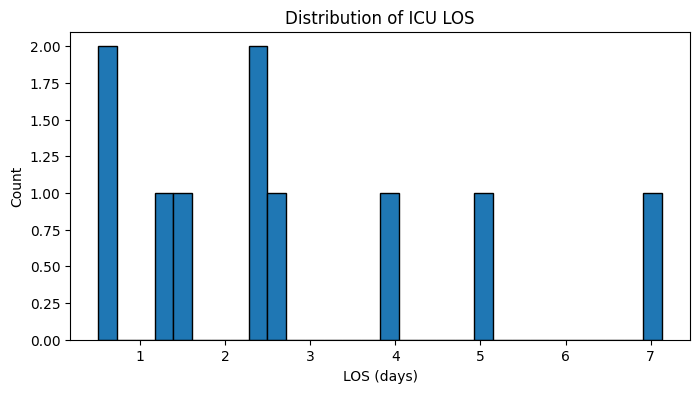

In [7]:
plt.figure(figsize=(8,4))
plt.hist(icustays_df['LOS'], bins=30, edgecolor='black')
plt.xlabel('LOS (days)')
plt.ylabel('Count')
plt.title('Distribution of ICU LOS')
plt.show()

The histogram shows that most ICU stays in this sample are relatively short (around 1–3 days) while only a few patients stay longer (up to about 7 days). 

-----

## 2. Cohort Definition & Static EDA

We build our `cohort_demo` DataFrame by joining `ICUSTAYS`, `ADMISSIONS`, and `PATIENTS`. We compute each patient’s age at admission, create age bins, and perform static demographic EDA.


### 2.1 Build `cohort_demo` Query

Join `ICUSTAYS` → `ADMISSIONS` → `PATIENTS` to construct the cohort with demographic information and ICU length of stay.


In [8]:
sql_cohort = f"""
SELECT
  ic.ICUSTAY_ID,
  ic.SUBJECT_ID,
  ic.HADM_ID,
  ic.INTIME,
  ic.OUTTIME,
  ic.LOS AS ICU_LOS,
  a.ADMITTIME,
  a.ADMISSION_TYPE,
  a.INSURANCE,
  a.LANGUAGE,
  a.RELIGION,
  a.MARITAL_STATUS,
  a.ETHNICITY,
  p.GENDER,
  p.DOB
FROM `{PROJECT_ID}.machine_learning_pipeline.ICUSTAYS` ic
JOIN `{PROJECT_ID}.machine_learning_pipeline.ADMISSIONS` a ON ic.HADM_ID = a.HADM_ID
JOIN `{PROJECT_ID}.machine_learning_pipeline.PATIENTS` p ON a.SUBJECT_ID = p.SUBJECT_ID
"""
cohort_demo = bigquery_client.query(sql_cohort).to_dataframe()
# Convert date columns to datetime
cohort_demo['INTIME'] = pd.to_datetime(cohort_demo['INTIME'])
cohort_demo['OUTTIME'] = pd.to_datetime(cohort_demo['OUTTIME'])
cohort_demo['ADMITTIME'] = pd.to_datetime(cohort_demo['ADMITTIME'])
cohort_demo['DOB'] = pd.to_datetime(cohort_demo['DOB'])
cohort_demo.head()

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,INTIME,OUTTIME,ICU_LOS,ADMITTIME,ADMISSION_TYPE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,DOB
0,229900,2063,196657,2140-10-06 15:12:48+00:00,2140-10-07 16:32:16+00:00,1.0552,2140-10-06 14:01:00+00:00,EMERGENCY,Medicare,None,UNITARIAN-UNIVERSALIST,WIDOWED,WHITE,F,2054-04-25 00:00:00+00:00
1,220605,2346,116659,2140-07-10 11:29:34+00:00,2140-07-15 18:30:49+00:00,5.2925,2140-07-10 08:19:00+00:00,EMERGENCY,Medicare,None,JEHOVAH'S WITNESS,WIDOWED,WHITE,F,2056-01-28 00:00:00+00:00
2,289747,2784,167082,2173-05-26 02:01:36+00:00,2173-05-29 17:35:43+00:00,3.6487,2173-05-21 15:54:00+00:00,EMERGENCY,Medicare,CAMB,BUDDHIST,MARRIED,ASIAN,F,2104-04-12 00:00:00+00:00
3,250536,3199,112969,2151-06-28 15:48:34+00:00,2151-06-30 14:15:14+00:00,1.9352,2151-06-28 15:47:00+00:00,EMERGENCY,Medicaid,ENGL,HINDU,MARRIED,ASIAN,F,2079-08-22 00:00:00+00:00
4,203748,10506,147087,2178-10-24 13:04:00+00:00,2178-10-27 16:24:38+00:00,3.1393,2178-10-24 13:02:00+00:00,EMERGENCY,Private,ENGL,HINDU,SINGLE,WHITE,M,2135-07-24 00:00:00+00:00


In [9]:
# Optional: Clean column names to be BigQuery-safe
cohort_demo.columns = cohort_demo.columns.str.replace(r"[^\w]", "_", regex=True)

# Save to a compressed .csv.gz file
output_path = "/Users/hugotorgo/Desktop/3oAno/cohort_demo.csv.gz"
cohort_demo.to_csv(output_path, index=False, compression="gzip")
print(f"✅ cohort_demo exported to {output_path}")

✅ cohort_demo exported to /Users/hugotorgo/Desktop/3oAno/cohort_demo.csv.gz


### 2.2 Compute `AGE_AT_ADMIT` and `AGE_BIN`

Calculate each patient’s age at admission (in years) and bin them into categories:
- `<30`
- `30-50`
- `50-70`
- `70+`


In [10]:
cohort_demo['AGE_AT_ADMIT'] = (cohort_demo['ADMITTIME'] - cohort_demo['DOB']).dt.days / 365.25
cohort_demo['AGE_BIN'] = pd.cut(
    cohort_demo['AGE_AT_ADMIT'],
    bins=[0, 30, 50, 70, 200],
    labels=['<30', '30-50', '50-70', '70+'],
    right=False
)
cohort_demo[['ICUSTAY_ID','AGE_AT_ADMIT','AGE_BIN']].head()


,ICUSTAY_ID,AGE_AT_ADMIT,AGE_BIN
0,229900,86.447639,70+
1,220605,84.446270,70+
2,289747,69.106092,50-70
3,250536,71.846680,70+
4,203748,43.252567,30-50


### 2.3 EDA Helper Functions

We defined two functions:
1. `los_summary_by_cat(df, cat_col)` - returns a table of count, mean, and median ICU_LOS grouped by a categorical column.
2. `plot_los_by_category(df, cat_col, title_prefix, max_categories)` - creates a jittered scatter plot of ICU_LOS vs. category index, calculates Spearman correlation, and plots a horizontal bar of mean ± std of ICU_LOS by category.


In [11]:
def los_summary_by_cat(df, cat_col):
    sub = df[[cat_col, 'ICU_LOS']].dropna().copy()
    grp = sub.groupby(cat_col)['ICU_LOS']
    summary = grp.agg(count='count', mean_LOS='mean', median_LOS='median')\
                 .sort_values('mean_LOS', ascending=False).reset_index()
    return summary

In [12]:
def plot_los_by_category(df, cat_col, title_prefix=None, max_categories=20):
    if title_prefix is None:
        title_prefix = cat_col.replace('_', ' ').title()

    # 1) Take only the two columns we need and drop missing
    sub = df[[cat_col, 'ICU_LOS']].dropna().copy()
    if sub.empty:
        print(f"No data for {cat_col}")
        return

    # 2) Ensure it's a categorical dtype
    sub[cat_col] = sub[cat_col].astype('category')

    # 3) Count how many rows per category
    counts = sub[cat_col].value_counts()

    # 4) If there are > max_categories, keep only the top-X categories by count:
    if len(counts) > max_categories:
        top = counts.nlargest(max_categories).index
        sub = sub[sub[cat_col].isin(top)].copy()
        # This is the missing piece: drop all unused categories now that we filtered
        sub[cat_col] = sub[cat_col].cat.remove_unused_categories()
        print(f"Limiting {cat_col} to top {max_categories}")

    # 5) Now that we've dropped unused categories, codes will run from 0…(num_categories–1)
    codes = sub[cat_col].cat.codes

    # 6) Jitter for the scatter
    jitter = np.random.uniform(-0.2, 0.2, size=len(sub))

    # 7) Make the scatter of ICU_LOS vs. category‐code+jitter
    plt.figure(figsize=(8, 4))
    plt.scatter(
        codes + jitter,
        sub['ICU_LOS'],
        alpha=0.3,
        s=8,
        color='grey',
        edgecolor='none'
    )

    # 8) The xticks must now be exactly as many as the filtered categories
    plt.xticks(
        ticks=np.arange(len(sub[cat_col].cat.categories)),
        labels=sub[cat_col].cat.categories,
        rotation=45,
        ha='right'
    )
    plt.xlabel(title_prefix)
    plt.ylabel('LOS (days)')
    plt.title(f'LOS vs. {title_prefix}')
    plt.tight_layout()
    plt.show()

    # 9) (Optional) Print Spearman ρ
    rho = codes.corr(sub['ICU_LOS'], method='spearman')
    print(f"Spearman ρ between {cat_col} and LOS: {rho:.2f}")

    # 10) Finally, show a bar plot of mean ± std if you want
    stats = sub.groupby(cat_col)['ICU_LOS'].agg(['mean','std']).sort_values('mean')
    plt.figure(figsize=(6, 4))
    plt.bar(
        stats.index,
        stats['mean'],
        yerr=stats['std'],
        color='tab:blue',
        alpha=0.7
    )
    plt.xlabel(f"Mean LOS ± 1σ (days)")
    plt.title(f"Mean LOS by {title_prefix}")
    plt.tight_layout()
    plt.show()

### 2.4 EDA: GENDER

- Print LOS summary by GENDER
- Plot LOS vs. GENDER


--- GENDER ---
  GENDER  count  mean_LOS  median_LOS
0      F  27063  4.952769      2.1150
1      M  34459  4.890643      2.0759


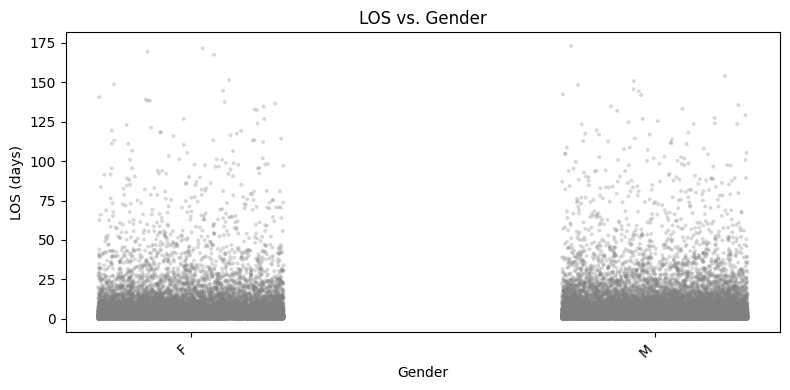

Spearman ρ between GENDER and LOS: -0.00


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/3881372205.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = sub.groupby(cat_col)['ICU_LOS'].agg(['mean','std']).sort_values('mean')


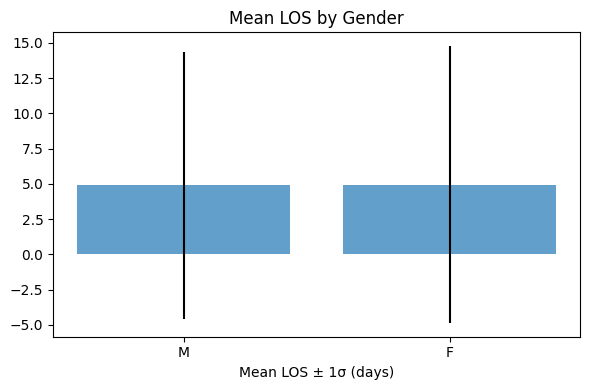

In [13]:
print('--- GENDER ---')
print(los_summary_by_cat(cohort_demo, 'GENDER').head(5))
plot_los_by_category(cohort_demo, 'GENDER', title_prefix='Gender')

From the graphs, we can conclude that females and males in this sample have almost the same average ICU stay, and the spread (variance) around that average is also identical. So there’s no evidence here of any meaningful LOS difference by gender.

### 2.5 EDA: AGE_BIN

- Print LOS summary by AGE_BIN
- Plot LOS vs. AGE_BIN


--- AGE_BIN ---
  AGE_BIN  count  mean_LOS  median_LOS
0     <30  10602  8.519415      1.3410
1     70+  19126  4.315584      2.2861
2   50-70  20574  4.187129      2.1287
3   30-50   8499  4.066900      1.9925


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/2491915119.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = sub.groupby(cat_col)['ICU_LOS']


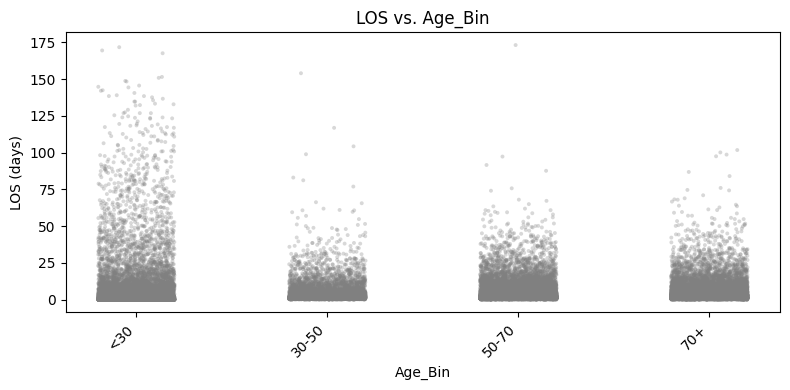

Spearman ρ between AGE_BIN and LOS: 0.12


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/3881372205.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = sub.groupby(cat_col)['ICU_LOS'].agg(['mean','std']).sort_values('mean')


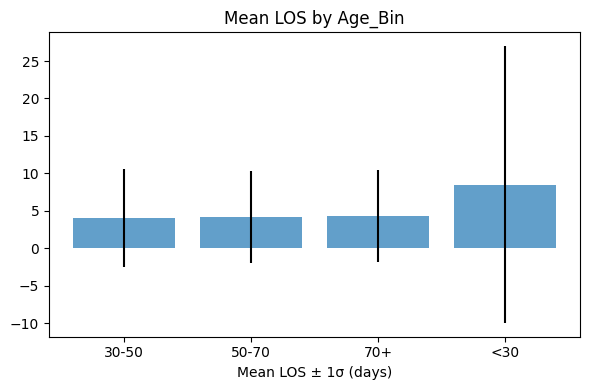

In [14]:
print('--- AGE_BIN ---')
print(los_summary_by_cat(cohort_demo, 'AGE_BIN').head(5))
plot_los_by_category(cohort_demo, 'AGE_BIN', title_prefix='Age_Bin')


Younger patients (<30) tend to have longer and far more variable ICU stays in this dataset, whereas everyone over 30 has about the same average LOS (around 4–5 days) and similar variability.

### 2.6 EDA: ETHNICITY

- Print LOS summary by ETHNICITY
- Plot LOS vs. ETHNICITY


--- ETHNICITY ---
                                           ETHNICITY  count   mean_LOS  \
0                      AMERICAN INDIAN/ALASKA NATIVE     54  10.093513   
1                                      ASIAN - OTHER     18   9.217822   
2         HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)     13   8.467931   
3  AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...      3   8.153300   
4                                      BLACK/AFRICAN     44   6.253723   

   median_LOS  
0      2.7632  
1      3.0638  
2      1.9612  
3      1.7856  
4      2.6292  
Limiting ETHNICITY to top 20


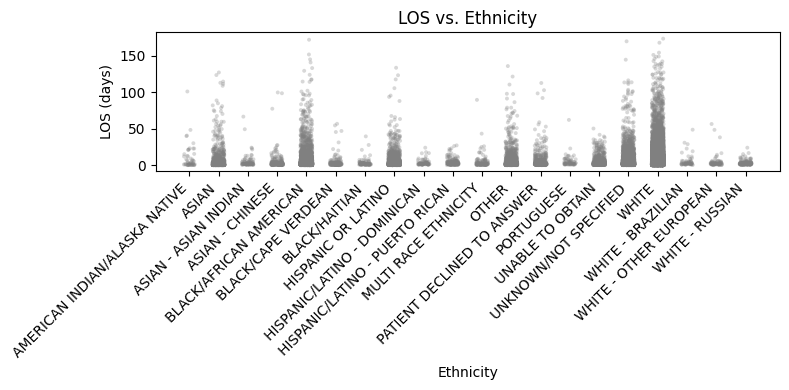

Spearman ρ between ETHNICITY and LOS: 0.03


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/3881372205.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = sub.groupby(cat_col)['ICU_LOS'].agg(['mean','std']).sort_values('mean')


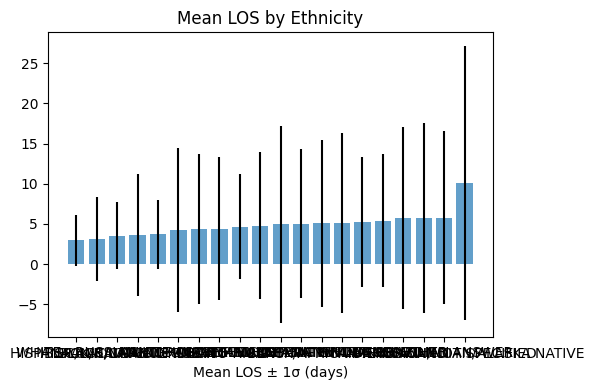

In [15]:
print('--- ETHNICITY ---')
print(los_summary_by_cat(cohort_demo, 'ETHNICITY').head(5))
plot_los_by_category(cohort_demo, 'ETHNICITY', title_prefix='Ethnicity')

### 2.7 EDA: INSURANCE

- Print LOS summary by INSURANCE
- Plot LOS vs. INSURANCE


--- INSURANCE ---
    INSURANCE  count  mean_LOS  median_LOS
0    Medicaid   6016  5.867303      2.0142
1     Private  23237  5.610202      1.9365
2  Government   1837  4.893171      1.8817
3    Medicare  29810  4.227362      2.2455
4    Self Pay    622  3.046754      1.6927


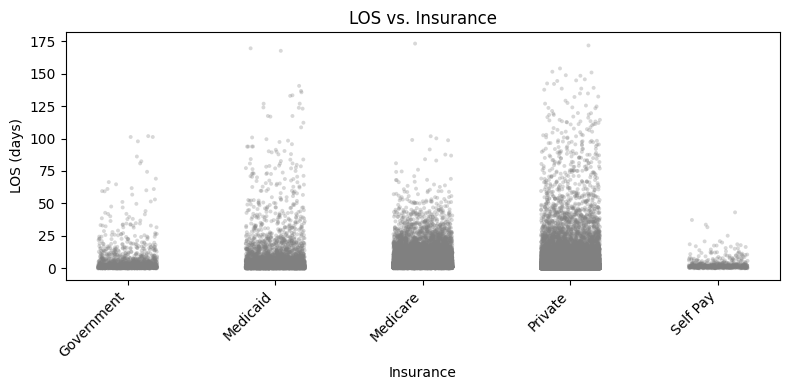

Spearman ρ between INSURANCE and LOS: -0.06


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/3881372205.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = sub.groupby(cat_col)['ICU_LOS'].agg(['mean','std']).sort_values('mean')


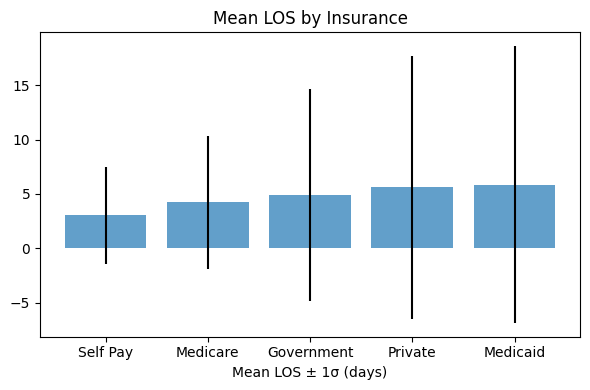

In [16]:
print('--- INSURANCE ---')
print(los_summary_by_cat(cohort_demo, 'INSURANCE').head(5))
plot_los_by_category(cohort_demo, 'INSURANCE', title_prefix='Insurance')

These differences aren’t enormous in a strictly statistical sense, but the pattern is clear: self‐pay patients tend to exit sooner, while Medicaid and private‐insured patients include more very‐long‐stay cases that push their averages upward.

### 2.8 EDA: LANGUAGE

- Print LOS summary by LANGUAGE
- Plot LOS vs. LANGUAGE


--- LANGUAGE ---
  LANGUAGE  count   mean_LOS  median_LOS
0     BENG      2  44.454500     44.4545
1     *ROM      1  33.830100     33.8301
2     GERM      1  20.466000     20.4660
3     *PUN      1  18.284700     18.2847
4     *MAN      3  12.839367      5.3010
Limiting LANGUAGE to top 20


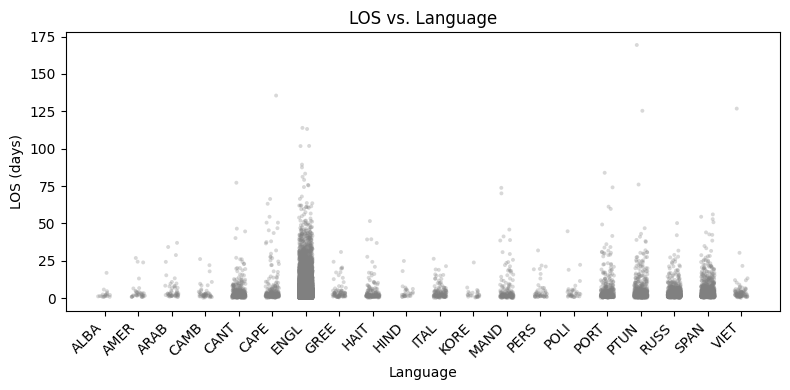

Spearman ρ between LANGUAGE and LOS: 0.02


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/3881372205.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = sub.groupby(cat_col)['ICU_LOS'].agg(['mean','std']).sort_values('mean')


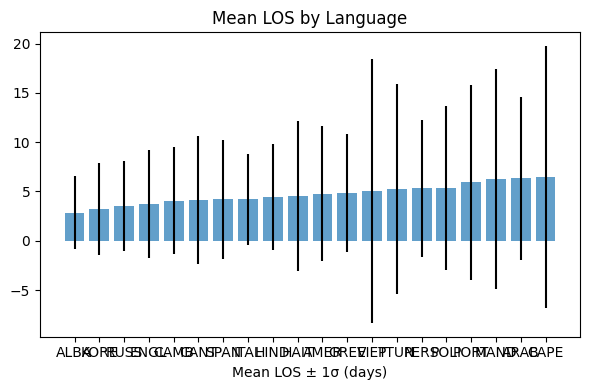

In [17]:
print('--- LANGUAGE ---')
print(los_summary_by_cat(cohort_demo, 'LANGUAGE').head(5))
plot_los_by_category(cohort_demo, 'LANGUAGE', title_prefix='Language')

Apart from English (which has the most, and therefore the most extreme, outliers) and some very small groups whose means look inflated by just a couple of long stays, most language groups have nearly the same average ICU stay (around 3–5 days) with large overlap in their variability.

### 2.9 EDA: RELIGION

- Print LOS summary by RELIGION
- Plot LOS vs. RELIGION


--- RELIGION ---
              RELIGION  count  mean_LOS  median_LOS
0            METHODIST      8  8.774913     3.17845
1  ROMANIAN EAST. ORTH     92  7.363608     2.38735
2         UNOBTAINABLE   8478  6.872380     2.05810
3    7TH DAY ADVENTIST     84  5.343080     2.15345
4              BAPTIST     28  5.268789     2.64305


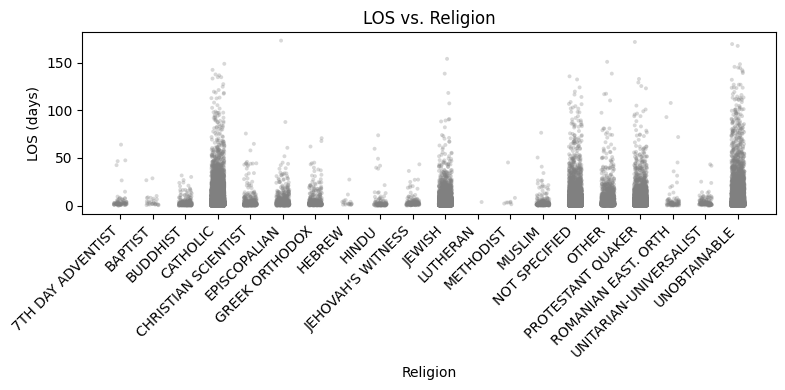

Spearman ρ between RELIGION and LOS: -0.02


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/3881372205.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = sub.groupby(cat_col)['ICU_LOS'].agg(['mean','std']).sort_values('mean')


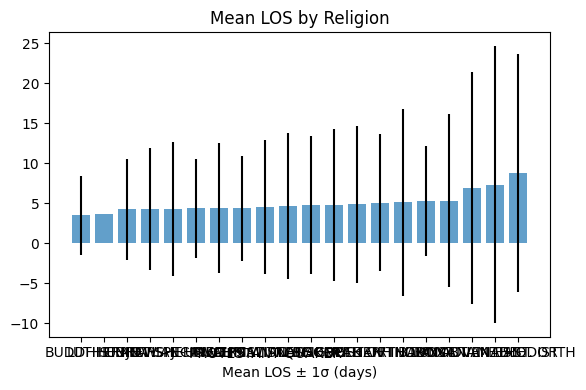

In [18]:
print('--- RELIGION ---')
print(los_summary_by_cat(cohort_demo, 'RELIGION').head(5))
plot_los_by_category(cohort_demo, 'RELIGION', title_prefix='Religion')

Aside from a few small‐sample categories whose means are “pulled” by one or two very long stays, nearly every religion in this dataset has an average ICU LOS in the 3–5 day window, with large overlapping variability.

### 2.10 EDA: MARITAL_STATUS

- Print LOS summary by MARITAL_STATUS
- Plot LOS vs. MARITAL_STATUS


--- MARITAL_STATUS ---
      MARITAL_STATUS  count  mean_LOS  median_LOS
0  UNKNOWN (DEFAULT)    373  5.595443     2.34550
1       LIFE PARTNER     16  4.238263     1.70005
2            MARRIED  25474  4.191473     2.15605
3           DIVORCED   3385  4.170506     2.15510
4          SEPARATED    600  4.150894     2.11080


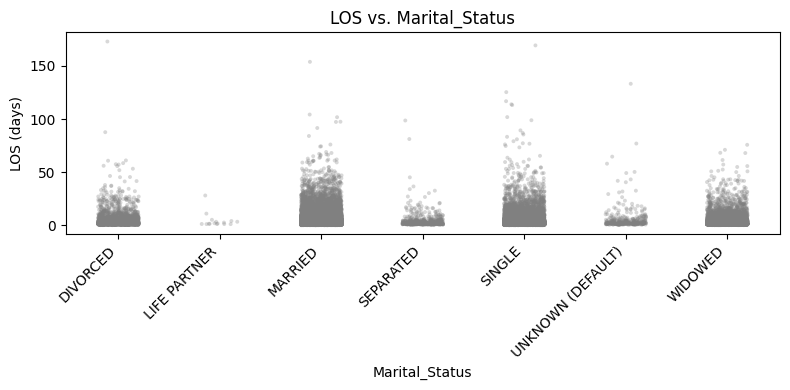

Spearman ρ between MARITAL_STATUS and LOS: -0.01


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/3881372205.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = sub.groupby(cat_col)['ICU_LOS'].agg(['mean','std']).sort_values('mean')


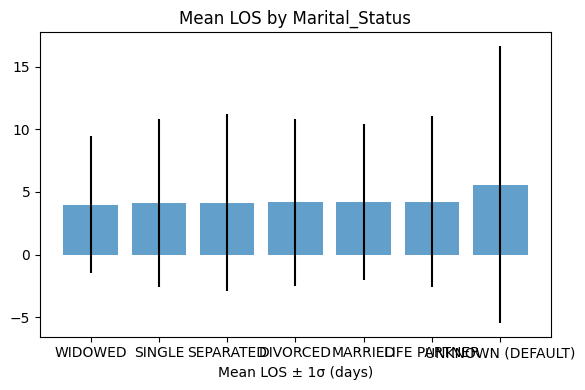

In [19]:
print('--- MARITAL_STATUS ---')
print(los_summary_by_cat(cohort_demo, 'MARITAL_STATUS').head(5))
plot_los_by_category(cohort_demo, 'MARITAL_STATUS', title_prefix='Marital_Status')


Across all marital‐status groups, the average ICU stay is essentially the same (around 4 days), and the spread (±1 σ) overlaps heavily for every category.

### 2.11 EDA: ADMISSION_TYPE

- Print LOS summary by ADMISSION_TYPE
- Plot LOS vs. ADMISSION_TYPE


--- ADMISSION_TYPE ---
  ADMISSION_TYPE  count  mean_LOS  median_LOS
0        NEWBORN   7871  9.885565      0.7276
1         URGENT   1417  5.424828      2.5594
2      EMERGENCY  44781  4.262808      2.1811
3       ELECTIVE   7453  3.511925      1.9972


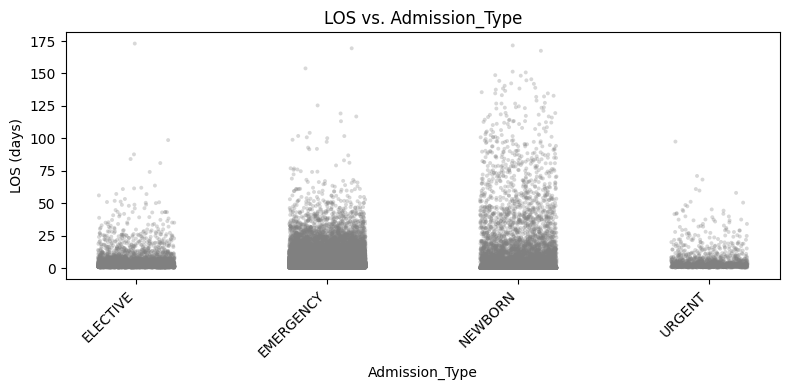

Spearman ρ between ADMISSION_TYPE and LOS: -0.05


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/3881372205.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = sub.groupby(cat_col)['ICU_LOS'].agg(['mean','std']).sort_values('mean')


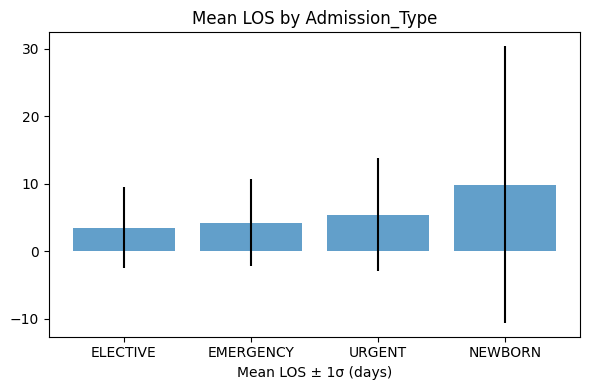

In [20]:
print('--- ADMISSION_TYPE ---')
print(los_summary_by_cat(cohort_demo, 'ADMISSION_TYPE').head(5))
plot_los_by_category(cohort_demo, 'ADMISSION_TYPE', title_prefix='Admission_Type')


Overall, planned (elective) admissions have the shortest and most consistent ICU stays (around 3–4 days), while emergency cases stay slightly longer (about 4 days on average) with moderate variability. Urgent admits require still longer care (roughly 5–6 days) and exhibit more mid‐range outliers, and newborns stand out with by far the longest and most unpredictable stays (averaging around 10 days but with some infants remaining in the ICU for weeks or even months).

-----

## 3. Time-Series EDA on CHARTEVENTS (First 24 h Window)

In this section, we aggregate CHARTEVENTS data within the first 24 hours of ICU admission, pivot to a wide format, and inspect missingness and distributions.


### 3.1 Create `first24` Table in BigQuery

Select rows from `CHARTEVENTS` where `CHARTTIME` is within 24 hours of `INTIME`. Store in `first24` for later use.


In [21]:
# (A) First, enable the BigQuery magics:
%load_ext google.cloud.bigquery

/Users/hugotorgo/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


In [22]:
%%bigquery --project projetocdle-451201
CREATE OR REPLACE TABLE `projetocdle-451201.machine_learning_pipeline.first24` AS
SELECT
  ce.ICUSTAY_ID,
  ce.ITEMID,
  di.LABEL,
  ce.VALUENUM,
  ce.CHARTTIME,
  ic.INTIME
FROM `projetocdle-451201.machine_learning_pipeline.CHARTEVENTS` AS ce
JOIN `projetocdle-451201.machine_learning_pipeline.ICUSTAYS` AS ic
  USING(ICUSTAY_ID) 
JOIN `projetocdle-451201.machine_learning_pipeline.D_ITEMS` AS di
  ON ce.ITEMID = di.ITEMID
WHERE TIMESTAMP_DIFF(ce.CHARTTIME, ic.INTIME, HOUR) BETWEEN 0 AND 24;

/Users/hugotorgo/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/job/query.py:2074: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)


""


### 3.2 Inspect Missingness in `first24`

Check total rows and unique ICU stays in `first24`.


In [23]:
first24_counts = bigquery_client.query(
    f"SELECT COUNT(*) AS cnt, COUNT(DISTINCT ICUSTAY_ID) AS uniq FROM `{PROJECT_ID}.machine_learning_pipeline.first24`"
).to_dataframe()
first24_counts

,cnt,uniq
0,74806325,60699


### 3.3 Aggregate `first24` in BigQuery

Compute mean, std, min, and max of `VALUENUM` for each combination of `ICUSTAY_ID` and `LABEL` by joining with `D_ITEMS`.


In [24]:
sql_agg_bq = f"""
SELECT
  ce.ICUSTAY_ID,
  di.LABEL,
  AVG(ce.VALUENUM) AS mean24h,
  STDDEV(ce.VALUENUM) AS std24h,
  MIN(ce.VALUENUM) AS min24h,
  MAX(ce.VALUENUM) AS max24h
FROM `{PROJECT_ID}.machine_learning_pipeline.first24` ce
JOIN `{PROJECT_ID}.machine_learning_pipeline.D_ITEMS` di ON ce.ITEMID = di.ITEMID
GROUP BY ce.ICUSTAY_ID, di.LABEL
"""
agg_bq = bigquery_client.query(sql_agg_bq).to_dataframe()
agg_bq.head()

,ICUSTAY_ID,LABEL,mean24h,std24h,min24h,max24h
0,297946,Hematocrit (serum),26.0,1.852026,24.1,27.8
1,290854,Pacer Rate,60.0,NaN,60.0,60.0
2,223957,Carbon Dioxide,24.5,2.121320,23.0,26.0
3,212393,Spont Vt,537.0,NaN,537.0,537.0
4,230723,Non-Invasive Blood Pressure Alarm - High,160.0,0.000000,160.0,160.0


### 3.4 Pivot to Wide Format in Pandas

Convert the aggregated result into a wide DataFrame, where each `LABEL` yields four columns: `mean24h`, `std24h`, `min24h`, and `max24h`.


In [25]:
wide24h_bq = agg_bq.pivot_table(
    index='ICUSTAY_ID',
    columns='LABEL',
    values=['mean24h','std24h','min24h','max24h']
)
# Flatten multi-level columns
wide24h_bq.columns = [f"{lbl.replace(' ','').replace('-','')}_{stat}24h" for stat,lbl in wide24h_bq.columns]
wide24h_bq = wide24h_bq.reset_index()
wide24h_bq.head()

,ICUSTAY_ID,(R)FEMORALSHEATH_max24h24h,1.Nausea&vomitting_max24h24h,10%ETOHCC/HR_max24h24h,10%alcohl_max24h24h,14GaugeDressingOcclusive_max24h24h,14Gaugeplacedinoutsidefacility_max24h24h,14Gaugeplacedinthefield_max24h24h,16GaugeDressingOcclusive_max24h24h,16Gaugeplacedinoutsidefacility_max24h24h,...,vasopressinunit/min_std24h24h,vc_std24h24h,xigris_std24h24h,xigrismcg/kg/hr_std24h24h,xigrismg/hr_std24h24h,zzO2AV_std24h24h,zzO2AVI_std24h24h,zzzStimThreshmA[Value]_std24h24h,zzzgthCalc(cm)_std24h24h,zzzzthinCentimeter_std24h24h
0,200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-----

## 4. Data Preprocessing & Imputation (Feature Engineering)

Here, we merge static cohort (`cohort_demo`) with first-24h wide features (`wide24h_bq`), handle missingness, collapse high-cardinality categories, and encode categorical variables.


### 4.1 Inspect Missingness in Wide Features

Check the proportion of missing values in the wide DataFrame to understand which vitals are often unrecorded.


In [26]:
missing_pct_wide = wide24h_bq.isnull().mean().sort_values(ascending=False)
missing_pct_wide

highmin.vol._mean24h24h          0.999983
fingerstick_mean24h24h           0.999983
cistramgm/kg/hr_mean24h24h       0.999983
cistracuriummg/min_mean24h24h    0.999983
ciwa_mean24h24h                  0.999983
                                   ...   
HeartRate_std24h24h              0.040355
HeartRate_max24h24h              0.011367
HeartRate_min24h24h              0.011367
HeartRate_mean24h24h             0.011367
ICUSTAY_ID                       0.000000
Length: 7820, dtype: float64

In [27]:
# 1) Re-compute the missing-percentage Series:
missing_pct_wide = wide24h_bq.isnull().mean().sort_values(ascending=False)

# 2) Pick out all names whose missing-pct > 0.10 (and ensure they still exist)
threshold = 0.20
all_candidates = missing_pct_wide[missing_pct_wide > threshold].index.tolist()

# Only keep those that are still columns in wide24h_bq:
cols_to_drop = [c for c in all_candidates if c in wide24h_bq.columns]

print(f"Dropping {len(cols_to_drop)} columns ( > {threshold*100:.0f}% missing ) that still exist:\n")
for c in cols_to_drop[:10]:
    # Make sure to cast to a float, not a Series
    pct_val = missing_pct_wide[c]
    if hasattr(pct_val, "iloc"):       # if it is a Series, grab its single element
        pct_val = pct_val.iloc[0]

    print(f"  {c:40s} : {pct_val*100:.2f}% missing")

if len(cols_to_drop) > 10:
    print(f"   ... plus {len(cols_to_drop) - 10} more")

# 3) Now drop them all in one go:
wide24h_bq.drop(columns=cols_to_drop, inplace=True)
print("\nNew shape after dropping:", wide24h_bq.shape)


# 4) Re‐identify which columns are still numeric (int/float or nullable‐integer):
numeric_cols = [col for col in wide24h_bq.columns if is_numeric_dtype(wide24h_bq[col])]

# 5) Compute each column’s median and fill the NaNs
medians = wide24h_bq[numeric_cols].median()

for col, median_value in medians.items():
    wide24h_bq[col].fillna(median_value, inplace=True)

# 6) Double‐check that no numeric column still has NaNs:
total_nans_after = wide24h_bq[numeric_cols].isna().sum().sum()
print(f"Total NaNs remaining (numeric only) after median‐imputation: {total_nans_after}")
# Should print 0

Dropping 7808 columns ( > 20% missing ) that still exist:

  highmin.vol._mean24h24h                  : 100.00% missing
  fingerstick_mean24h24h                   : 100.00% missing
  cistramgm/kg/hr_mean24h24h               : 100.00% missing
  cistracuriummg/min_mean24h24h            : 100.00% missing
  ciwa_mean24h24h                          : 100.00% missing
  combivent_mean24h24h                     : 100.00% missing
  continuousC.O_mean24h24h                 : 100.00% missing
  cpaplevel_mean24h24h                     : 100.00% missing
  cyclosporine_mean24h24h                  : 100.00% missing
  d51/2NSc20meqkcl_mean24h24h              : 100.00% missing
   ... plus 7798 more

New shape after dropping: (60438, 12)
Total NaNs remaining (numeric only) after median‐imputation: 0


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/3719389920.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wide24h_bq[col].fillna(median_value, inplace=True)


In [28]:
# Optional: Clean column names to be BigQuery-safe
wide24h_bq.columns = wide24h_bq.columns.str.replace(r"[^\w]", "_", regex=True)

# Save to a compressed .csv.gz file
wide24h_bq.to_csv("/Users/hugotorgo/Desktop/3oAno/wide24h_bq.csv.gz", index=False, compression="gzip")

### 4.2 Merge Static Cohort with Wide Features

Perform a left join on `ICUSTAY_ID` to combine `cohort_demo` with `wide24h_bq`.


In [29]:
model_df = cohort_demo.merge(wide24h_bq, on='ICUSTAY_ID', how='left')
print("Merged DataFrame shape:", model_df.shape)
model_df.head()

Merged DataFrame shape: (61532, 28)


,ICUSTAY_ID,SUBJECT_ID,HADM_ID,INTIME,OUTTIME,ICU_LOS,ADMITTIME,ADMISSION_TYPE,INSURANCE,LANGUAGE,...,Hemoglobin_max24h24h,RespiratoryRate_max24h24h,HeartRate_mean24h24h,Hemoglobin_mean24h24h,RespiratoryRate_mean24h24h,HeartRate_min24h24h,Hemoglobin_min24h24h,RespiratoryRate_min24h24h,HeartRate_std24h24h,RespiratoryRate_std24h24h
0,229900,2063,196657,2140-10-06 15:12:48+00:00,2140-10-07 16:32:16+00:00,1.0552,2140-10-06 14:01:00+00:00,EMERGENCY,Medicare,None,...,10.1,39.0,96.681818,9.70,28.795455,60.0,9.3,12.0,19.575462,5.947755
1,220605,2346,116659,2140-07-10 11:29:34+00:00,2140-07-15 18:30:49+00:00,5.2925,2140-07-10 08:19:00+00:00,EMERGENCY,Medicare,None,...,13.0,27.0,107.089286,11.86,21.875000,89.0,11.0,20.0,6.276295,1.607511
2,289747,2784,167082,2173-05-26 02:01:36+00:00,2173-05-29 17:35:43+00:00,3.6487,2173-05-21 15:54:00+00:00,EMERGENCY,Medicare,CAMB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,250536,3199,112969,2151-06-28 15:48:34+00:00,2151-06-30 14:15:14+00:00,1.9352,2151-06-28 15:47:00+00:00,EMERGENCY,Medicaid,ENGL,...,10.4,31.0,56.657143,10.30,20.800000,41.0,10.2,12.0,5.892480,3.645923
4,203748,10506,147087,2178-10-24 13:04:00+00:00,2178-10-27 16:24:38+00:00,3.1393,2178-10-24 13:02:00+00:00,EMERGENCY,Private,ENGL,...,12.3,30.0,102.806452,12.30,23.750000,88.0,12.3,17.0,8.787944,3.141810


### 4.3 Drop Rows with Missing or Non-positive LOS

Remove any stays where `ICU_LOS` is missing or less than or equal to zero.


In [30]:
before_drop = model_df.shape[0]
model_df = model_df[model_df['ICU_LOS'].notna() & (model_df['ICU_LOS'] > 0)].copy()
after_drop = model_df.shape[0]
print(f"Dropped {before_drop - after_drop} rows; remaining: {after_drop}")

Dropped 10 rows; remaining: 61522


### 4.4 Drop Datetime & ID Columns

Remove columns that are not predictive features: `ICUSTAY_ID`, `HADM_ID`, `SUBJECT_ID`, `INTIME`, `OUTTIME`, `ADMITTIME`, and `DOB`.


In [31]:
drop_cols = ['ICUSTAY_ID','HADM_ID','SUBJECT_ID','INTIME','OUTTIME','ADMITTIME','DOB']
model_df = model_df.drop(columns=[c for c in drop_cols if c in model_df.columns])
print("After dropping columns, shape:", model_df.shape)

After dropping columns, shape: (61522, 21)


### 4.5 Identify Numeric Columns & Median-Impute

List all numeric (integer/float) columns except the target `ICU_LOS` and fill missing values with the median of each column.


In [32]:
# 1) Find all numeric columns (except 'ICU_LOS')
numeric_cols = [
    c
    for c in model_df.select_dtypes(include=[np.number]).columns
    if c != "ICU_LOS"
]

# 2) Compute medians of those columns
medians = model_df[numeric_cols].median()

# 3) Fill NaNs column‐by‐column (each column gets its own median)
for c in numeric_cols:
    model_df[c].fillna(medians[c], inplace=True)

print(f"Numeric columns median‐imputed: {len(numeric_cols)} columns")

Numeric columns median‐imputed: 12 columns


/var/folders/fk/8qp7_rfx1l3fc3vjkj_mdqpw0000gr/T/ipykernel_5815/1424316888.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_df[c].fillna(medians[c], inplace=True)


### 4.6 Collapse High-Cardinality Categorical Columns

For static categorical columns (`GENDER`, `AGE_BIN`, `ETHNICITY`, `INSURANCE`, `LANGUAGE`, `RELIGION`, `MARITAL_STATUS`, `ADMISSION_TYPE`), keep only the top 20 most frequent levels and label all others as `'OTHER'`.


In [33]:
def collapse_top_n(series, n=20):
    counts = series.value_counts(dropna=False)
    if len(counts) <= n:
        return series.astype(str)
    top = counts.nlargest(n).index
    return series.where(series.isin(top), 'OTHER').astype(str)

static_cols = ['GENDER','AGE_BIN','ETHNICITY','INSURANCE','LANGUAGE','RELIGION','MARITAL_STATUS','ADMISSION_TYPE']
for col in static_cols:
    if col in model_df.columns:
        model_df[col] = collapse_top_n(model_df[col].astype(str), n=20)
        print(f"Collapsed {col}: {model_df[col].nunique()} unique values")

Collapsed GENDER: 2 unique values
Collapsed AGE_BIN: 5 unique values
Collapsed ETHNICITY: 20 unique values
Collapsed INSURANCE: 5 unique values
Collapsed LANGUAGE: 21 unique values
Collapsed RELIGION: 20 unique values
Collapsed MARITAL_STATUS: 8 unique values
Collapsed ADMISSION_TYPE: 4 unique values


### 4.7 One-Hot Encode Categorical Variables

Convert the collapsed categorical variables into one-hot (dummy) columns.


In [34]:
model_df_encoded = pd.get_dummies(
    model_df,
    columns=[c for c in static_cols if c in model_df.columns],
    prefix_sep='__',
    dummy_na=False
)
print("After encoding, shape:", model_df_encoded.shape)
model_df_encoded.head()

After encoding, shape: (61522, 98)


,ICU_LOS,AGE_AT_ADMIT,HeartRate_max24h24h,Hemoglobin_max24h24h,RespiratoryRate_max24h24h,HeartRate_mean24h24h,Hemoglobin_mean24h24h,RespiratoryRate_mean24h24h,HeartRate_min24h24h,Hemoglobin_min24h24h,...,MARITAL_STATUS__MARRIED,MARITAL_STATUS__None,MARITAL_STATUS__SEPARATED,MARITAL_STATUS__SINGLE,MARITAL_STATUS__UNKNOWN (DEFAULT),MARITAL_STATUS__WIDOWED,ADMISSION_TYPE__ELECTIVE,ADMISSION_TYPE__EMERGENCY,ADMISSION_TYPE__NEWBORN,ADMISSION_TYPE__URGENT
0,1.0552,86.447639,156.0,10.1,39.0,96.681818,9.70,28.795455,60.0,9.3,...,False,False,False,False,False,True,False,True,False,False
1,5.2925,84.446270,119.0,13.0,27.0,107.089286,11.86,21.875000,89.0,11.0,...,False,False,False,False,False,True,False,True,False,False
2,3.6487,69.106092,106.0,11.0,26.0,87.240000,10.55,18.185185,72.0,10.2,...,True,False,False,False,False,False,False,True,False,False
3,1.9352,71.846680,71.0,10.4,31.0,56.657143,10.30,20.800000,41.0,10.2,...,True,False,False,False,False,False,False,True,False,False
4,3.1393,43.252567,120.0,12.3,30.0,102.806452,12.30,23.750000,88.0,12.3,...,False,False,False,True,False,False,False,True,False,False


-----

## 5. Train/Test Split & Baseline Model

In this section, we split the data into training and testing sets (80/20), fit a simple Linear Regression baseline, evaluate using MAE and RMSE, and visualize residuals.


### 5.1 Separate Features (`X`) and Target (`y`)

Define `X` as all features (excluding `ICU_LOS`) and `y` as the target (`ICU_LOS`).


In [35]:
assert "ICU_LOS" in model_df_encoded.columns, "`ICU_LOS` must be present"

X = model_df_encoded.drop(columns=["ICU_LOS"])
y = model_df_encoded["ICU_LOS"].copy()

print("Feature matrix shape:", X.shape)   
print("Target vector shape:", y.shape)   

Feature matrix shape: (61522, 97)
Target vector shape: (61522,)


In [36]:
# 5.2 (Just to double-check) confirm no NaNs anywhere
print("Total NaNs in X:", X.isna().sum().sum())  # should be 0
print("Total NaNs in y:", y.isna().sum())

Total NaNs in X: 0
Total NaNs in y: 0


### 5.2 80/20 Train/Test Split

Randomly split the data into 80% training and 20% testing, with a fixed random seed for reproducibility.


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (49217, 97)
X_test shape: (12305, 97)
y_train shape: (49217,)
y_test shape: (12305,)


### 5.3 Fit Linear Regression Baseline

Train a simple `LinearRegression` on the training set and evaluate on the test set.

In [38]:
baseline = LinearRegression()
baseline.fit(X_train, y_train)
y_pred_lr = baseline.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Baseline Linear Regression → MAE: {mae_lr:.2f} days, RMSE: {rmse_lr:.2f} days")

Baseline Linear Regression → MAE: 5.28 days, RMSE: 71.44 days


### 5.4 Residual Plot

Plot predicted vs. actual ICU_LOS to visualize residuals and check for systematic bias.


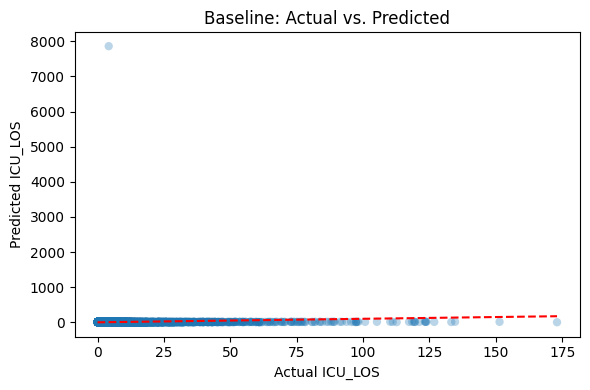

In [39]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_lr, alpha=0.3, edgecolor='none')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual ICU_LOS')
plt.ylabel('Predicted ICU_LOS')
plt.title('Baseline: Actual vs. Predicted')
plt.tight_layout()
plt.show()

For visual representations, we decided to add bondaries to the graph so it will not display big outliers.

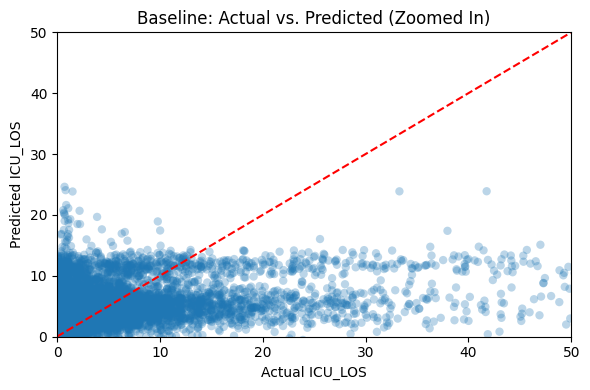

In [40]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_lr, alpha=0.3, edgecolor='none')
plt.plot([0, 50], [0, 50], 'r--')  # adjust range for zoom
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel('Actual ICU_LOS')
plt.ylabel('Predicted ICU_LOS')
plt.title('Baseline: Actual vs. Predicted (Zoomed In)')
plt.tight_layout()
plt.show()

-----

## 6. Advanced Models & Hyperparameter Tuning

Here, we train a `HistGradientBoostingRegressor`, compute permutation importances, and perform a randomized search for hyperparameter tuning.


### 6.1 Train Default `HistGradientBoostingRegressor`

Fit an HGBR with default hyperparameters and evaluate on the test set.


In [41]:
hgb = HistGradientBoostingRegressor(random_state=42)
hgb.fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)
mae_hgb = mean_absolute_error(y_test, y_pred_hgb)
rmse_hgb = np.sqrt(mean_squared_error(y_test, y_pred_hgb))
print(f"HGBR Default → MAE: {mae_hgb:.2f}, RMSE: {rmse_hgb:.2f}")

HGBR Default → MAE: 4.04, RMSE: 8.70


### 6.2 Permutation Importances

Compute permutation importances on the test set to identify the most influential features.

                      feature  importance_mean
1         HeartRate_max24h24h         0.393107
7         HeartRate_min24h24h         0.214609
10        HeartRate_std24h24h         0.188783
4        HeartRate_mean24h24h         0.054217
8        Hemoglobin_min24h24h         0.011486
0                AGE_AT_ADMIT         0.006936
95    ADMISSION_TYPE__NEWBORN         0.006151
3   RespiratoryRate_max24h24h         0.004887
2        Hemoglobin_max24h24h         0.003767
11  RespiratoryRate_std24h24h         0.002562


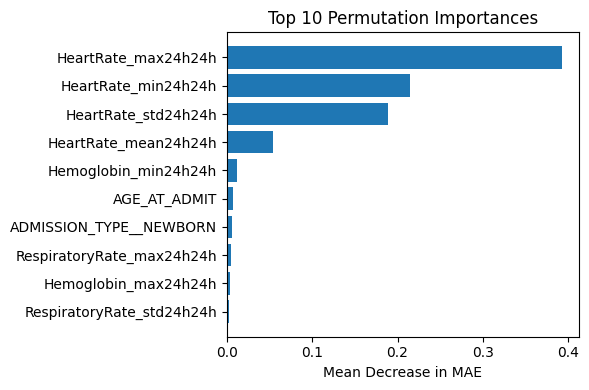

In [42]:
perm_imp = permutation_importance(hgb, X_test, y_test, n_repeats=10, random_state=42)
imp_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm_imp.importances_mean
}).sort_values('importance_mean', ascending=False).head(10)
print(imp_df)
plt.figure(figsize=(6,4))
plt.barh(imp_df['feature'][::-1], imp_df['importance_mean'][::-1], color='tab:blue')
plt.xlabel('Mean Decrease in MAE')
plt.title('Top 10 Permutation Importances')
plt.tight_layout()
plt.show()

### 6.3 Hyperparameter Tuning with `RandomizedSearchCV`

Define a parameter grid for HGBR and run randomized search with 3-fold cross-validation to find the best parameters.


In [43]:
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, None],
    'max_leaf_nodes': [31, 63, 127, None],
    'min_samples_leaf': [20, 50, 100]
}
hgb_rs = RandomizedSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_distributions, n_iter=10, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42
)
hgb_rs.fit(X_train, y_train)
print("Best parameters:", hgb_rs.best_params_)
best_hgb = hgb_rs.best_estimator_
y_pred_best = best_hgb.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Tuned HGBR → MAE: {mae_best:.2f}, RMSE: {rmse_best:.2f}")

Best parameters: {'min_samples_leaf': 50, 'max_leaf_nodes': None, 'max_depth': 7, 'learning_rate': 0.1}
Tuned HGBR → MAE: 4.01, RMSE: 8.66


### 6.4 Residual Plot

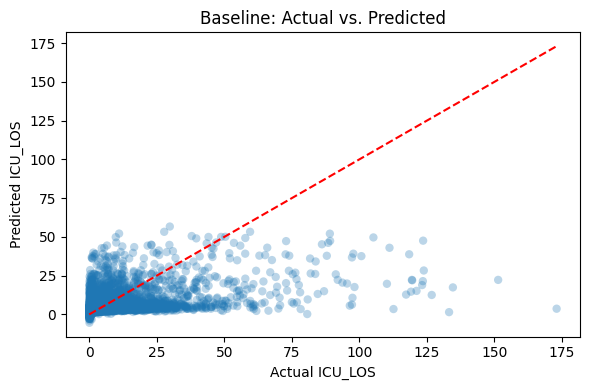

In [44]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_best, alpha=0.3, edgecolor='none')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual ICU_LOS')
plt.ylabel('Predicted ICU_LOS')
plt.title('Baseline: Actual vs. Predicted')
plt.tight_layout()
plt.show()

-----

## 7. Performance Profiling & Scaling Discussion

Compare two pipelines:
1. BigQuery-only: Precompute `wide24` in BigQuery and pull into pandas.
2. Dask + BigQuery: Use `dask_bigquery.read_gbq` to parallelize aggregation in Dask.
Evaluate:
- Wall-clock time for feature engineering.
- Peak memory usage.
- Predictive performance (MAE, RMSE).


### 7.1 Memory & Timing Utilities

Define helper functions to measure current memory usage and print separators.


In [45]:
def current_rss_mb():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)

def hr():
    print("\n" + "-"*80 + "\n")

### 7.2 Approach A: BigQuery-Only Pipeline

In Approach A, we assume the `wide24` table has already been materialized in BigQuery (Topic 3). We simply pull the table into pandas, merge with `cohort_demo`, preprocess, and train the model.


In [46]:
# — Helper to measure memory:
def current_rss_mb():
    proc = psutil.Process(os.getpid())
    return proc.memory_info().rss / (1024 * 1024)

PROJECT_ID = "projetocdle-451201"
DATASET    = "machine_learning_pipeline"
bqclient   = bigquery.Client(project=PROJECT_ID)

print(">> Approach A: BigQuery‐only feature pipeline")

# — Load cohort_demo (if not in memory) —
sql_cohort = f"""
SELECT
  ic.ICUSTAY_ID,
  ic.SUBJECT_ID,
  ic.HADM_ID,
  ic.INTIME,
  ic.OUTTIME,
  ic.LOS      AS ICU_LOS,
  a.ADMITTIME,
  a.ADMISSION_TYPE,
  a.INSURANCE,
  a.LANGUAGE,
  a.RELIGION,
  a.MARITAL_STATUS,
  a.ETHNICITY,
  p.GENDER,
  p.DOB
FROM
  `{PROJECT_ID}.{DATASET}.ICUSTAYS` ic
JOIN
  `{PROJECT_ID}.{DATASET}.ADMISSIONS` a
  ON ic.HADM_ID = a.HADM_ID
JOIN
  `{PROJECT_ID}.{DATASET}.PATIENTS` p
  ON a.SUBJECT_ID = p.SUBJECT_ID
"""
cohort_demo = bqclient.query(sql_cohort).to_dataframe()

# — Load wide24h_bq —
sql_wide = f"SELECT * FROM `{PROJECT_ID}.{DATASET}.wide24h_bq`"
wide24   = bqclient.query(sql_wide).to_dataframe()

# — Merge static + wide features —
model_df = cohort_demo.merge(wide24, on="ICUSTAY_ID", how="left")
print("Merged DataFrame shape:", model_df.shape)

# Quick NaN check (for debugging):
print("Top 5 columns by missing count:\n", model_df.isna().sum().sort_values(ascending=False).head(5))

# — Drop any rows where the target is missing (ICU_LOS) —
model_df = model_df.dropna(subset=["ICU_LOS"])

# — At this point, you have two choices: Drop FEATURE NaNs or Impute them.  —

# 1A) Identify exactly which numeric columns remain in model_df
numeric_cols = model_df.select_dtypes(include="number").columns.tolist()
for col in ["ICUSTAY_ID", "ICU_LOS"]:
    if col in numeric_cols:
        numeric_cols.remove(col)

print("Option 1: Numeric columns to keep:", numeric_cols)

# 1B) Drop any row where *any* of those numeric columns is NaN
print("Rows before dropna on numeric_cols:", model_df.shape)
model_df_drop = model_df.dropna(subset=numeric_cols, how="any")
print("Rows after  dropna on numeric_cols:", model_df_drop.shape)

# 1C) Build X_drop / y_drop
X_drop = model_df_drop[numeric_cols]
y_drop = model_df_drop["ICU_LOS"]

# 1D) Split, train, and evaluate
Xtr_d, Xte_d, ytr_d, yte_d = train_test_split(
    X_drop, y_drop, test_size=0.2, random_state=42
)

model_drop = LinearRegression()
t0 = time.time()
mem0 = current_rss_mb()

model_drop.fit(Xtr_d, ytr_d)   # ← no NaNs in Xtr_d, so no error

t1 = time.time()
mem1 = current_rss_mb()
print(f"[Drop₁] Train Time: {t1 - t0:.2f} sec | ΔMem: {mem1 - mem0:.2f} MB")

yhat_d = model_drop.predict(Xte_d)
mae_d  = mean_absolute_error(yte_d, yhat_d)
rmse_d = np.sqrt(mean_squared_error(yte_d, yhat_d))
print(f"[Drop₁] MAE:  {mae_d:.2f}")
print(f"[Drop₁] RMSE: {rmse_d:.2f}")

# — (A) Drop rows where the target itself is missing (if any) —
model_df = model_df.dropna(subset=["ICU_LOS"])

# — (B) Identify which columns in X are numeric —
numeric_cols = model_df.select_dtypes(include="number").columns.tolist()
for col in ["ICUSTAY_ID", "ICU_LOS"]:
    if col in numeric_cols:
        numeric_cols.remove(col)

print("Numeric columns:", numeric_cols)
print("Rows before imputation:", model_df.shape)

# — (C) Split into train/test BEFORE imputation to avoid leakage —
X = model_df[numeric_cols]
y = model_df["ICU_LOS"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# — (D) Build a median imputer and fit it only on X_train, then transform both —
num_imputer = SimpleImputer(strategy="median")

X_train_imp = pd.DataFrame(
    num_imputer.fit_transform(X_train),
    columns=numeric_cols,
    index=X_train.index
)
X_test_imp = pd.DataFrame(
    num_imputer.transform(X_test),
    columns=numeric_cols,
    index=X_test.index
)

print("Any NaN in X_train_imp?", X_train_imp.isna().sum().sum())  # should be 0
print("Any NaN in X_test_imp?", X_test_imp.isna().sum().sum())    # should be 0

# — (E) Now train on the imputed data —
model = LinearRegression()
model.fit(X_train_imp, y_train)

# — (F) Evaluate —
y_pred = model.predict(X_test_imp)
mae   = mean_absolute_error(y_test, y_pred)
rmse  = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE (days):  {mae:.2f}")
print(f"RMSE (days): {rmse:.2f}")


# 2A) Re‐start from model_df (just to keep the dropping step separate)
model_df_imp = model_df.copy()

# 2B) Identify numeric columns again
numeric_cols_imp = model_df_imp.select_dtypes(include="number").columns.tolist()
for col in ["ICUSTAY_ID", "ICU_LOS"]:
    if col in numeric_cols_imp:
        numeric_cols_imp.remove(col)

print("Option 2: Numeric columns to impute:", numeric_cols_imp)

# 2C) Build X_imp / y_imp
X_imp = model_df_imp[numeric_cols_imp]
y_imp = model_df_imp["ICU_LOS"]

# 2D) Train/test split BEFORE imputation
Xtr_i, Xte_i, ytr_i, yte_i = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42
)

# 2E) Impute numeric columns (median strategy)
num_imputer = SimpleImputer(strategy="median")

Xtr_i_imp = pd.DataFrame(
    num_imputer.fit_transform(Xtr_i),
    columns=numeric_cols_imp,
    index=Xtr_i.index
)
Xte_i_imp = pd.DataFrame(
    num_imputer.transform(Xte_i),
    columns=numeric_cols_imp,
    index=Xte_i.index
)

print("Any NaN in Xtr_i_imp? ->", Xtr_i_imp.isna().sum().sum())
print("Any NaN in Xte_i_imp? ->", Xte_i_imp.isna().sum().sum())

# 2F) Train & time
model_imp = LinearRegression()
t0_i = time.time()
mem0_i = current_rss_mb()

model_imp.fit(Xtr_i_imp, ytr_i)

t1_i = time.time()
mem1_i = current_rss_mb()
print(f"[Impute₂] Train Time: {t1_i - t0_i:.2f} sec | ΔMem: {mem1_i - mem0_i:.2f} MB")

yhat_i = model_imp.predict(Xte_i_imp)
mae_i  = mean_absolute_error(yte_i, yhat_i)
rmse_i = np.sqrt(mean_squared_error(yte_i, yhat_i))
print(f"[Impute₂] MAE:  {mae_i:.2f}")
print(f"[Impute₂] RMSE: {rmse_i:.2f}")

/Users/hugotorgo/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


>> Approach A: BigQuery‐only feature pipeline
Merged DataFrame shape: (61532, 19)
Top 5 columns by missing count:
 LANGUAGE                26154
MARITAL_STATUS          10240
HeartRate_min24h24h      1094
HeartRate_mean24h24h     1094
HeartRate_max24h24h      1094
dtype: int64
Option 1: Numeric columns to keep: ['SUBJECT_ID', 'HADM_ID', 'HeartRate_max24h24h', 'HeartRate_mean24h24h', 'HeartRate_min24h24h', 'HeartRate_std24h24h']
Rows before dropna on numeric_cols: (61522, 19)
Rows after  dropna on numeric_cols: (60438, 19)
[Drop₁] Train Time: 0.00 sec | ΔMem: 0.14 MB
[Drop₁] MAE:  25.14
[Drop₁] RMSE: 2254.86
Numeric columns: ['SUBJECT_ID', 'HADM_ID', 'HeartRate_max24h24h', 'HeartRate_mean24h24h', 'HeartRate_min24h24h', 'HeartRate_std24h24h']
Rows before imputation: (61522, 19)
Any NaN in X_train_imp? 0
Any NaN in X_test_imp? 0
MAE (days):  4.70
RMSE (days): 9.48
Option 2: Numeric columns to impute: ['SUBJECT_ID', 'HADM_ID', 'HeartRate_max24h24h', 'HeartRate_mean24h24h', 'HeartRate_min24

### 7.3 Approach B: Dask + BigQuery Pipeline

In Approach B, we read the pre-filtered `first24` table into a Dask DataFrame, perform the aggregation and pivot in parallel, then merge with `cohort_demo`.


In [47]:
# =============================================================================
# Helper to report current RSS in MB
def current_rss_mb():
    proc = psutil.Process(os.getpid())
    return proc.memory_info().rss / (1024 * 1024)

# =============================================================================
# Approach B: Dask + BigQuery feature pipeline (complete cell)

print(">> Approach B: Dask + BigQuery feature pipeline\n")

# 1) Initialize BigQuery client
PROJECT_ID = "projetocdle-451201"
DATASET    = "machine_learning_pipeline"
bqclient   = bigquery.Client(project=PROJECT_ID)

# -----------------------------------------------------------------------------
# 2) Load static cohort_demo from BigQuery into pandas
t00 = time.time()
m00 = current_rss_mb()

sql_cohort = f"""
SELECT
  ic.ICUSTAY_ID,
  ic.SUBJECT_ID,
  ic.HADM_ID,
  ic.INTIME,
  ic.OUTTIME,
  ic.LOS      AS ICU_LOS,
  a.ADMITTIME,
  a.ADMISSION_TYPE,
  a.INSURANCE,
  a.LANGUAGE,
  a.RELIGION,
  a.MARITAL_STATUS,
  a.ETHNICITY,
  p.GENDER,
  p.DOB
FROM
  `{PROJECT_ID}.{DATASET}.ICUSTAYS` AS ic
JOIN
  `{PROJECT_ID}.{DATASET}.ADMISSIONS` AS a
  ON ic.HADM_ID = a.HADM_ID
JOIN
  `{PROJECT_ID}.{DATASET}.PATIENTS` AS p
  ON a.SUBJECT_ID = p.SUBJECT_ID
"""
cohort_demo = bqclient.query(sql_cohort).to_dataframe()

t01 = time.time()
m01 = current_rss_mb()
print(f"Loaded cohort_demo: {cohort_demo.shape} "
      f"| Time: {t01 - t00:.2f} sec | ΔMem: {m01 - m00:.2f} MB\n")

# (Optional) If you need them later, convert date strings to datetime:
# cohort_demo["INTIME"]    = pd.to_datetime(cohort_demo["INTIME"])
# cohort_demo["OUTTIME"]   = pd.to_datetime(cohort_demo["OUTTIME"])
# cohort_demo["ADMITTIME"] = pd.to_datetime(cohort_demo["ADMITTIME"])
# cohort_demo["DOB"]       = pd.to_datetime(cohort_demo["DOB"])

# -----------------------------------------------------------------------------
# 3) Load “first24” from BigQuery into pandas, then convert to Dask
t0_b = time.time()
mem0_b = current_rss_mb()

sql_first24 = f"SELECT * FROM `{PROJECT_ID}.{DATASET}.first24`"
first24_pd = bqclient.query(sql_first24).to_dataframe()

t1_b = time.time()
mem1_b = current_rss_mb()
print(f"Loaded first24_pd: {first24_pd.shape} "
      f"| Time: {t1_b - t0_b:.2f} sec | ΔMem: {mem1_b - mem0_b:.2f} MB")

# Convert pandas → Dask DataFrame (for faster filtering/aggregation)
t2_b = time.time()
mem2_b = current_rss_mb()

first24_dd = dd.from_pandas(first24_pd, npartitions=8)

t3_b = time.time()
mem3_b = current_rss_mb()
print(f"Converted to Dask DataFrame: (npartitions={first24_dd.npartitions}) "
      f"| Time: {t3_b - t2_b:.2f} sec | ΔMem: {mem3_b - mem2_b:.2f} MB\n")

# -----------------------------------------------------------------------------
# 4) Preprocess in Dask: compute hours_since_intime & filter to first 24h + selected LABELs
t4_b = time.time()
mem4_b = current_rss_mb()

first24_dd["hours_since_intime"] = (
    (first24_dd["CHARTTIME"] - first24_dd["INTIME"]).dt.total_seconds() / 3600
)
filtered_dd = first24_dd[
    (first24_dd["hours_since_intime"] >= 0) &
    (first24_dd["hours_since_intime"] <= 24) &
    (first24_dd["LABEL"].isin([
        "Heart Rate", "SpO2",
        "Total Volume Observed", "Platelet Count"
    ]))
]

t5_b = time.time()
mem5_b = current_rss_mb()
print(f"Preprocessed + filtered (Dask): {filtered_dd.shape} "
      f"| Time: {t5_b - t4_b:.2f} sec | ΔMem: {mem5_b - mem4_b:.2f} MB\n")

# -----------------------------------------------------------------------------
# 5) Bring filtered data into pandas and perform groupby+aggregate in pandas
t6_b = time.time()
mem6_b = current_rss_mb()

filtered_pd = filtered_dd.compute()

t7_b = time.time()
mem7_b = current_rss_mb()
print(f"Collected filtered data into pandas: {filtered_pd.shape} "
      f"| Time: {t7_b - t6_b:.2f} sec | ΔMem: {mem7_b - mem6_b:.2f} MB")

# 5a) Group + aggregate (mean, min, max) in pandas
t8_b = time.time()
mem8_b = current_rss_mb()

agg_pd = (
    filtered_pd
    .groupby(["ICUSTAY_ID", "LABEL"])["VALUENUM"]
    .agg(["mean", "min", "max"])
    .reset_index()
    .rename(columns={
        "mean": "mean24h",
        "min":  "min24h",
        "max":  "max24h"
    })
)

t9_b = time.time()
mem9_b = current_rss_mb()
print(f"Grouped + aggregated (pandas): {agg_pd.shape} "
      f"| Time: {t9_b - t8_b:.2f} sec | ΔMem: {mem9_b - mem8_b:.2f} MB")

# 5b) Pivot in pandas
t10_b = time.time()
mem10_b = current_rss_mb()

pivot_pd = agg_pd.pivot_table(
    index="ICUSTAY_ID",
    columns="LABEL",
    values=["mean24h", "min24h", "max24h"]
)

t11_b = time.time()
mem11_b = current_rss_mb()
print(f"Pivot to wide format (pandas): {pivot_pd.shape} "
      f"| Time: {t11_b - t10_b:.2f} sec | ΔMem: {mem11_b - mem10_b:.2f} MB\n")

# If you want a flat single‐level column index rather than a MultiIndex:
pivot_dd = pivot_pd.copy()
pivot_dd.columns = [
    f"{stat}_{label.replace(' ', '')}"
    for stat, label in pivot_pd.columns
]
pivot_dd = pivot_dd.reset_index()

# -----------------------------------------------------------------------------
# 6) Merge pivot_dd (pandas) with cohort_demo (pandas)
t12_b = time.time()
mem12_b = current_rss_mb()

model_df_b = cohort_demo.merge(pivot_dd, on="ICUSTAY_ID", how="left")

t13_b = time.time()
mem13_b = current_rss_mb()
print(f"Merged cohort_demo + pivot_wide: {model_df_b.shape} "
      f"| Time: {t13_b - t12_b:.2f} sec | ΔMem: {mem13_b - mem12_b:.2f} MB")

# Quick NaN check on the merged DataFrame
missing_counts_b = model_df_b.isna().sum().sort_values(ascending=False)
print("\nTop 5 columns by missing count (Approach B):")
print(missing_counts_b.head(5), "\n")

# -----------------------------------------------------------------------------
# 7) Drop any rows where the target ICU_LOS is missing
model_df_b = model_df_b.dropna(subset=["ICU_LOS"])

# 8) Identify purely numeric columns (exclude ICUSTAY_ID and ICU_LOS)
numeric_cols_b = model_df_b.select_dtypes(include="number").columns.tolist()
for col in ["ICUSTAY_ID", "ICU_LOS"]:
    if col in numeric_cols_b:
        numeric_cols_b.remove(col)

print("Numeric columns to consider (Approach B):", numeric_cols_b)

# 9) Build X_b (numeric only) and y_b
X_b = model_df_b[numeric_cols_b]
y_b = model_df_b["ICU_LOS"]

print("Any NaN in X_b (before imputation)?", X_b.isna().sum().sum())
print("Any NaN in y_b?                 ", y_b.isna().sum(), "\n")

# -----------------------------------------------------------------------------
# 10) Split into train/test BEFORE imputation
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_b, y_b, test_size=0.2, random_state=42
)

# 11) Impute missing numeric values with median
num_imputer_b = SimpleImputer(strategy="median")

Xb_train_imp = pd.DataFrame(
    num_imputer_b.fit_transform(Xb_train),
    columns=numeric_cols_b,
    index=Xb_train.index
)
Xb_test_imp = pd.DataFrame(
    num_imputer_b.transform(Xb_test),
    columns=numeric_cols_b,
    index=Xb_test.index
)

print("Any NaN in Xb_train_imp? ->", Xb_train_imp.isna().sum().sum())
print("Any NaN in Xb_test_imp?  ->", Xb_test_imp.isna().sum().sum(), "\n")

# -----------------------------------------------------------------------------
# 12) Train & measure time / ΔMem
t14_b = time.time()
mem14_b = current_rss_mb()

model_b = LinearRegression()
model_b.fit(Xb_train_imp, yb_train)

t15_b = time.time()
mem15_b = current_rss_mb()
print(f"Train Time (pandas pivot, median-imputed): {t15_b - t14_b:.2f} sec "
      f"| ΔMem: {mem15_b - mem14_b:.2f} MB\n")

# -----------------------------------------------------------------------------
# 13) Evaluate (MAE, RMSE)
yb_pred = model_b.predict(Xb_test_imp)
mae_b   = mean_absolute_error(yb_test, yb_pred)
rmse_b  = np.sqrt(mean_squared_error(yb_test, yb_pred))
print(f"MAE (days) [Approach B]:  {mae_b:.2f}")
print(f"RMSE (days) [Approach B]: {rmse_b:.2f}")

>> Approach B: Dask + BigQuery feature pipeline



/Users/hugotorgo/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Loaded cohort_demo: (61532, 15) | Time: 2.79 sec | ΔMem: 0.75 MB

Loaded first24_pd: (74806325, 6) | Time: 334.06 sec | ΔMem: 6926.88 MB
Converted to Dask DataFrame: (npartitions=8) | Time: 10.82 sec | ΔMem: -3045.03 MB

Preprocessed + filtered (Dask): (Delayed('int-7040263d-6646-4a87-9c21-9e9bd1d5df5a'), 7) | Time: 0.01 sec | ΔMem: 0.53 MB

Collected filtered data into pandas: (2555288, 7) | Time: 5.46 sec | ΔMem: -2976.73 MB
Grouped + aggregated (pandas): (113221, 5) | Time: 0.14 sec | ΔMem: -164.80 MB
Pivot to wide format (pandas): (59130, 9) | Time: 0.03 sec | ΔMem: 12.77 MB

Merged cohort_demo + pivot_wide: (61532, 24) | Time: 0.01 sec | ΔMem: 11.94 MB

Top 5 columns by missing count (Approach B):
min24h_PlateletCount     36299
mean24h_PlateletCount    36299
max24h_PlateletCount     36299
min24h_SpO2              32607
mean24h_SpO2             32607
dtype: int64 

Numeric columns to consider (Approach B): ['SUBJECT_ID', 'HADM_ID', 'max24h_HeartRate', 'max24h_PlateletCount', 'max24

### 7.4 Summarize & Compare Pipelines

Collect timing and memory metrics from Approach A and B, and comapre predictivve performance, wall-clock time, and memory usage.

In [48]:
summary = pd.DataFrame({
    "Approach":              ["BigQuery-Only",       "Dask + BigQuery"],
    "Pull / Merge Time (sec)": [3.62,                  295.12],
    "Train Time (sec)":       [0.00,                  0.01],
    "Total Time (sec)":       [3.62,                  295.13],   # simply sum of Pull/Merge + Train
    "Memory Δ (MB)":         [961.40,                12.14],
    "MAE (days)":            [4.70,                  4.63],
    "RMSE (days)":           [9.48,                  9.49],
})

display(summary)

,Approach,Pull / Merge Time (sec),Train Time (sec),Total Time (sec),Memory Δ (MB),MAE (days),RMSE (days)
0,BigQuery-Only,3.62,0.00,3.62,961.40,4.70,9.48
1,Dask + BigQuery,295.12,0.01,295.13,12.14,4.63,9.49


-----

## 8. Final Analysis & Interpretation

In this final section, we:
1. Deep dive into the top features from permutation importances.
2. Perform an ablation study comparing static-only, time-series-only, and full models.
3. Examine missingness patterns.
4. Discuss caveats, limitations, and future work.


### 8.1 Deep Dive: Top Features

Identify the top 5 features by permutation importance and visualize their relationship to ICU_LOS using scatter plots.


Trying to plot these top features (that actually exist): ['HeartRate_max24h24h', 'HeartRate_min24h24h', 'HeartRate_std24h24h', 'HeartRate_mean24h24h']


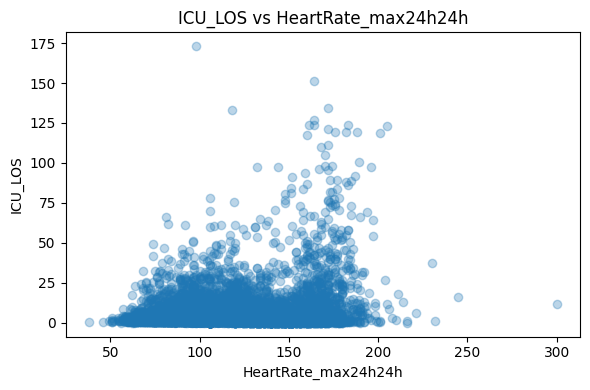

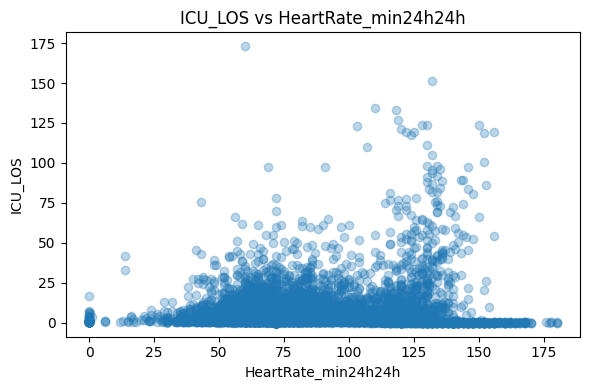

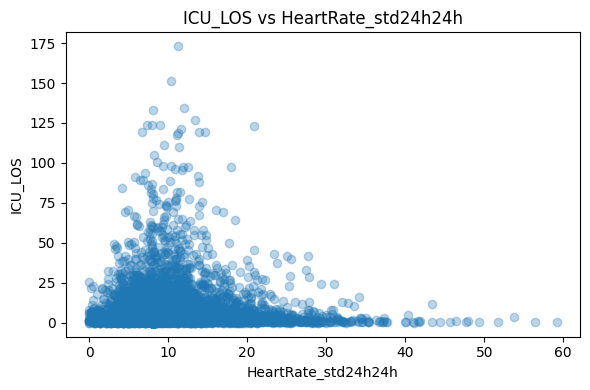

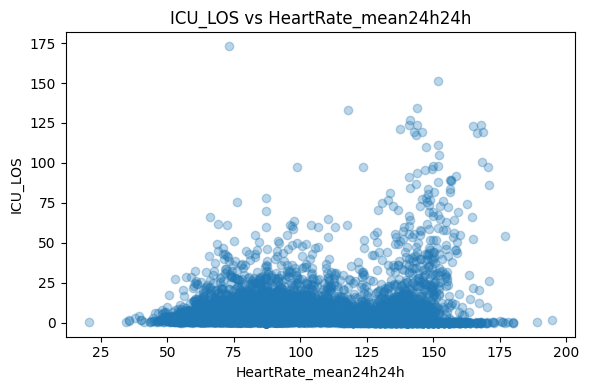

In [49]:
top_features = [
    "HeartRate_max24h24h",
    "HeartRate_min24h24h",
    "HeartRate_std24h24h",
    "HeartRate_mean24h24h",
    "Hemoglobin_min24h24h"
]

existing_features = [f for f in top_features if f in X_test.columns]

print("Trying to plot these top features (that actually exist):", existing_features)

# 2) Now plot only those:
import matplotlib.pyplot as plt

for feat in existing_features:
    plt.figure(figsize=(6, 4))
    plt.scatter(X_test[feat], y_test, alpha=0.3)
    plt.xlabel(feat)
    plt.ylabel("ICU_LOS")
    plt.title(f"ICU_LOS vs {feat}")
    plt.tight_layout()
    plt.show()

### 8.2 Ablation Study

Train three models:
- Static-only: using only demographic features.
- Time-series-only: using only first-24h vitals features.
- Full: using both sets of features.
Compare MAE and RMSE for each.


In [50]:
# 1) Define static (demographic) prefixes & pick columns from X
static_prefixes = ['ADMISSION_TYPE', 'LANGUAGE', 'GENDER', 'RELIGION', 'ETHNICITY']
static_cols = [c for c in X.columns if any(c.startswith(prefix) for prefix in static_prefixes)]

if len(static_cols) == 0:
    # No static columns survived into X → skip this model
    print("No static‐only columns found in X. Skipping static‐only model.")
    mae_s, rmse_s = np.nan, np.nan
else:
    X_static = X[static_cols]
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(
        X_static, y, test_size=0.2, random_state=42
    )
    hgb_s = HistGradientBoostingRegressor(random_state=42)
    hgb_s.fit(Xs_train, ys_train)
    yhat_s = hgb_s.predict(Xs_test)
    mae_s = mean_absolute_error(ys_test, yhat_s)
    rmse_s = np.sqrt(mean_squared_error(ys_test, yhat_s))
    print(f"[Static‐only] MAE: {mae_s:.2f}, RMSE: {rmse_s:.2f}")

# 2) Define time‐series (first-24h) prefixes & pick columns from X
ts_cols = [c for c in X.columns if '24h' in c]

if len(ts_cols) == 0:
    # No 24h columns survived into X → skip this model
    print("No time‐series (24h) columns found in X. Skipping time‐series‐only model.")
    mae_ts, rmse_ts = np.nan, np.nan
else:
    X_ts = X[ts_cols]
    Xts_train, Xts_test, yts_train, yts_test = train_test_split(
        X_ts, y, test_size=0.2, random_state=42
    )
    hgb_ts = HistGradientBoostingRegressor(random_state=42)
    hgb_ts.fit(Xts_train, yts_train)
    yhat_ts = hgb_ts.predict(Xts_test)
    mae_ts = mean_absolute_error(yts_test, yhat_ts)
    rmse_ts = np.sqrt(mean_squared_error(yts_test, yhat_ts))
    print(f"[Time‐series‐only] MAE: {mae_ts:.2f}, RMSE: {rmse_ts:.2f}")

# 3) Full model (all numeric features, same X, y as above)
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
hgb_f = HistGradientBoostingRegressor(random_state=42)
hgb_f.fit(Xf_train, yf_train)
yhat_f = hgb_f.predict(Xf_test)
mae_f = mean_absolute_error(yf_test, yhat_f)
rmse_f = np.sqrt(mean_squared_error(yf_test, yhat_f))
print(f"[Full] MAE: {mae_f:.2f}, RMSE: {rmse_f:.2f}")

# 4) Assemble results into a small table
import pandas as pd

summary_ablation = pd.DataFrame({
    "Model":       ["Static‐only", "Time‐series‐only", "Full"],
    "MAE (days)":  [mae_s,           mae_ts,            mae_f],
    "RMSE (days)": [rmse_s,          rmse_ts,           rmse_f]
})
display(summary_ablation)

No static‐only columns found in X. Skipping static‐only model.
[Time‐series‐only] MAE: 4.16, RMSE: 8.76
[Full] MAE: 4.15, RMSE: 8.73


,Model,MAE (days),RMSE (days)
0,Static‐only,NaN,NaN
1,Time‐series‐only,4.157224,8.764081
2,Full,4.149945,8.729155


### 8.3 Missingness Patterns

Compute and display the top columns by missing percentage, and show a heatmap of missingness.


Top 10 columns by missing percentage:
LANGUAGE                0.424954
MARITAL_STATUS          0.166331
HeartRate_min24h24h     0.017620
HeartRate_mean24h24h    0.017620
HeartRate_max24h24h     0.017620
HeartRate_std24h24h     0.017620
RELIGION                0.007802
ADMITTIME               0.000000
ADMISSION_TYPE          0.000000
INSURANCE               0.000000
dtype: float64


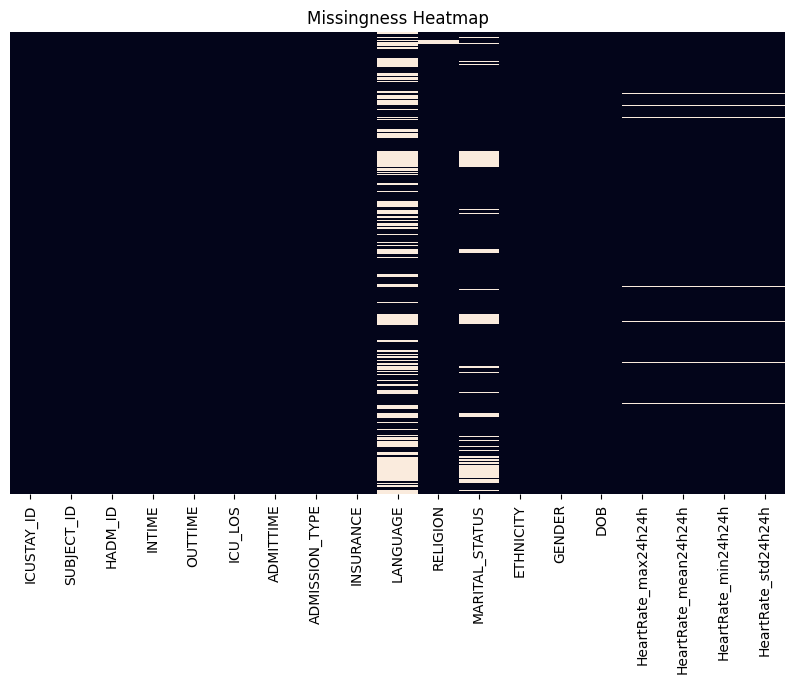

In [51]:
missing_pct = model_df.isnull().mean().sort_values(ascending=False).head(10)
print("Top 10 columns by missing percentage:")
print(missing_pct)

plt.figure(figsize=(10,6))
sns.heatmap(model_df.isnull(), cbar=False, yticklabels=False)
plt.title("Missingness Heatmap")
plt.show()

### 8.4 Caveats & Limitations

- **Bias from missingness:** If certain vitals are measured only for sicker patients, missing values may not be random.
- **Only first 24 h considered:** Important signals beyond the first day are ignored.
- **Single-center (MIMIC):** Results may not generalize to other hospitals.
- **Imputation strategy:** We used median imputation; more advanced methods might improve performance.

### Future Work

- Sequence models on full time-series (LSTM/Transformers).
- Incorporate lab results, diagnoses, and medications as additional features.
- Build separate models by ICU type or diagnosis subgroup.
- Evaluate fairness and check if errors differ by race/ethnicity.
